In [1]:
# Bring your packages onto the path
import sys, os
# include directory 3 levels up 
# for 1 level up '..' 
# for 2 levels '../..'
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # module for progress bar (https://pypi.org/project/tqdm/)

# custom package where all models are written
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator # model
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator_samples # sample generator
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator_isoprob_transform

import Surrogates.KarhunenLoeveExpansion as KLE

# Model evaluations

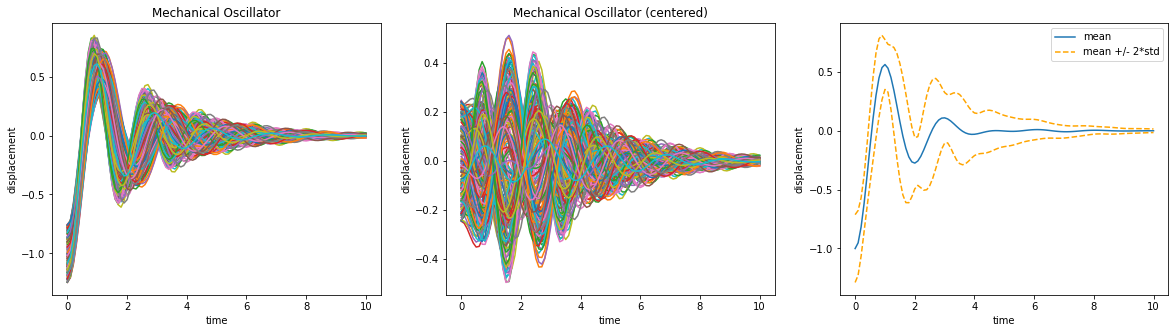

In [3]:
N = 10_000 # number of 'instances'/'realisations'

n_t = 101

t = np.linspace(0, 10, n_t) # row vector
T = np.tile(t, (N, 1)) # repeat row 't' along axis 0

SampleSpace = mech_oscillator_samples(N) # generate samples

Y = mech_oscillator(SampleSpace, T) # compute output (displacement) [N, n_t]

Y_mean = np.mean(Y, axis=0) # compute mean for each t_i
Y_std = np.std(Y, axis=0) # compute std for each t_i

# center the process
Y_c = Y-Y_mean

'Plots'
fig, ax = plt.subplots(1, 3, figsize=(20,5))

'Plot 200 realisations of the random process'
for i in np.arange(200):
    ax[0].plot(t,Y[i,:], '-')
ax[0].set_ylabel('displacement')
ax[0].set_xlabel('time')
ax[0].set_title('Mechanical Oscillator')

for i in np.arange(200):
    ax[1].plot(t,Y_c[i,:], '-')
ax[1].set_ylabel('displacement')
ax[1].set_xlabel('time')
ax[1].set_title('Mechanical Oscillator (centered)')

'Plot the mean and 2 stds of random process'
ax[2].plot(t,Y_mean, '-', label = 'mean')
ax[2].plot(t,Y_mean+2*Y_std, '--', color = 'orange', label = 'mean +/- 2*std')
ax[2].plot(t,Y_mean-2*Y_std, '--', color = 'orange')
ax[2].set_ylabel('displacement')
ax[2].set_xlabel('time')
ax[2].legend()

plt.show()

Variance quantified by 10 terms = 0.9999955458255047


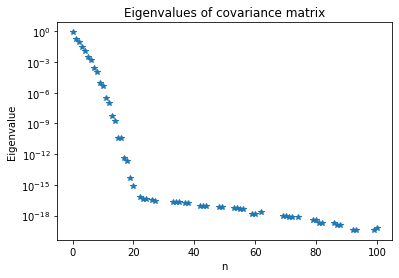

Number of PCE terms: 286
Number of evaluations needed (empirical estimate): 572
Number of function evaluations: 5000


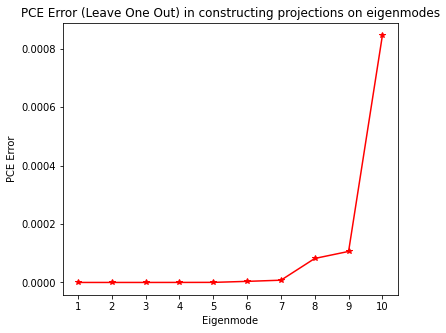

In [17]:
total_polynomial_degree = 10
number_of_random_variables = 3
polynomial_classes_of_random_variables = ['Legendre']*number_of_random_variables

# truncation level for KLE
n_kl = 10

test = KLE.KLE(SampleSpace, Y, t, total_polynomial_degree, n_kl, 
                polynomial_classes_of_random_variables, mech_oscillator_isoprob_transform, PCE_error_flag = True)

# test.plot_eigenvectors() # only even n_kl
# test.plot_projections() # only even n_kl

# Sobol Indices

Using Pick and Freeze method

In [18]:
def pick_and_freeze(model, I, N, N_p, A, B):
    """
    Point-wise first and total order Sobol Indices

    Inputs:
        model = function that returns output of model for given input
                Input:  ndarray
                        [N, N_p]
                Output: [n_t, N]
                        Model evaluations for desired set of parameters
                        Each column has ouput of 1 set of parameters
        I = list or 1D array
            Indices in solution at which Sobol indices must be computed
        N = int
            number of MC samples
        N_p = int
              number of parameters
        A = ndarray
            First set of random inputs of size [N, N_p]
        B = ndarray
            Second set of random inputs of size [N, N_p]
        
    Outputs:
        S = ndarray
            [n, num_of_points] 
            num_of_points = len(num_of_points)
            First-order sensitivity of each the 'n' parameters
            at each I 

        S_T = ndarray
              [n,1]
              num_of_points = len(num_of_points)
              Total sensitivity of each the 'n' parameters
              at each I
    """

    def get_C_i(i):
        C_i = np.copy(B)
        C_i[:,i] = A[:,i]
        return C_i

    f_A = model(A) # [n_t, N] vector with evaluations at x_A
    f_B = model(B) # [n_t, N] vector with evaluations at x_B

    # store f_C
    f_C = np.zeros((f_A.shape[0], f_A.shape[1], N_p)) # [n_t, N, N_p] 3d array with evaluations at x_C_i

    for i in tqdm(range(N_p), desc = 'Computing f_C', ncols=100):
        f_C[:, :, i] = model(get_C_i(i)) # [n_t, N] vector with evaluations at x_C_i

    f_0 = np.mean(f_A, axis=1) # [n_t, 1] mean over N realisation for each discretisation point

    num_of_points = len(I)

    S = np.zeros((N_p, num_of_points))
    S_T = np.zeros((N_p, num_of_points))

    for j, time_index in enumerate(tqdm(I, desc = 'Computing Indices', ncols=100)):

        for i in range(N_p):
            f_A_local = f_A[time_index, :].T # [N, 1] vector
            f_B_local = f_B[time_index, :].T # [N, 1] vector
            f_C_local = f_C[time_index, :, i].T # [N, 1] vector
            f_0_local = f_0[time_index]

            # denominator is common in both terms
            # V[Y] = E[Y**2] - E[Y]**2
            total_variance = (np.dot(f_A_local, f_A_local)/N) - f_0_local**2

            # First order indices
            # Each column contains indices corresponding to a point in I
            S[i, j] = ( (np.dot(f_A_local, f_C_local)/N) - f_0_local**2 )  / ( total_variance )

            # Total indices
            # Each column contains indices corresponding to a point in I
            S_T[i, j] = 1 - ( (np.dot(f_B_local, f_C_local)/N - f_0_local**2) ) / ( total_variance )  

    return S, S_T

In [19]:
def mech_oscillator_wrapper(parameters):

    return test.surrogate_evaluate(parameters).T

Total number of function evalutions = 250000


Computing Indices: 100%|████████████████████████████████████████| 101/101 [00:00<00:00, 6170.25it/s]


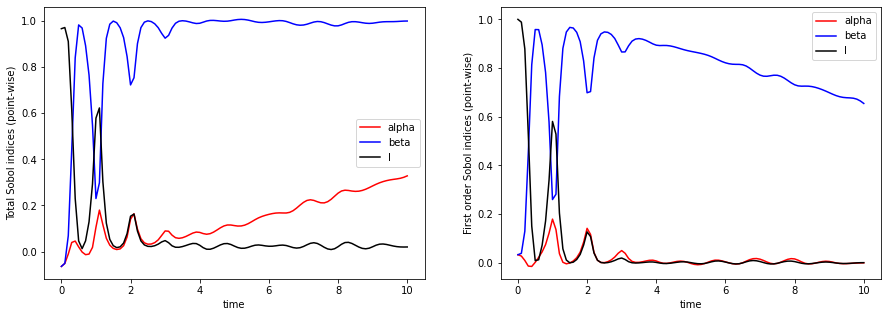

In [20]:
N = 50_000 # number of MC samples

A = mech_oscillator_samples(N)
B = mech_oscillator_samples(N)

n_t = 100  # discretization in time
T = np.linspace(0, 10, n_t+1) # row vector

inspection_points = 101

I = np.linspace(0 , n_t, inspection_points, dtype=int)

print(f'Total number of function evalutions = {N*(3+2)}')

S, S_T = pick_and_freeze(mech_oscillator_wrapper, I, N, 3, A, B)

'Plots'

fig, ax = plt.subplots(1, 2,figsize=(15,5))

ax[0].plot(T, S_T[0,:], '-', color = 'red', label = 'alpha')
ax[0].plot(T, S_T[1,:], '-', color = 'blue', label = 'beta')
ax[0].plot(T, S_T[2,:], '-', color = 'black', label = 'l')
ax[0].legend()
ax[0].set_xlabel('time')
ax[0].set_ylabel('Total Sobol indices (point-wise)')

ax[1].plot(T, S[0,:], '-', color = 'red', label = 'alpha')
ax[1].plot(T, S[1,:], '-', color = 'blue', label = 'beta')
ax[1].plot(T, S[2,:], '-', color = 'black', label = 'l')
ax[1].legend()
ax[1].set_xlabel('time')
ax[1].set_ylabel('First order Sobol indices (point-wise)')

plt.show()